In [1]:
import os

total_images = 0

for dirname, _, filenames in os.walk('/kaggle/input'):
    if filenames:  # if there are files in this folder
        num_files = len(filenames)
        print(f"Folder '{dirname}' processed with {num_files} files.")
        total_images += num_files

print(f"Finished reading all folders. Total images: {total_images}")


Folder '/kaggle/input/dyselxia/Gambo/Test/Reversal' processed with 17882 files.
Folder '/kaggle/input/dyselxia/Gambo/Test/Corrected' processed with 19284 files.
Folder '/kaggle/input/dyselxia/Gambo/Test/Normal' processed with 19557 files.
Folder '/kaggle/input/dyselxia/Gambo/Train/Reversal' processed with 46781 files.
Folder '/kaggle/input/dyselxia/Gambo/Train/Corrected' processed with 65534 files.
Folder '/kaggle/input/dyselxia/Gambo/Train/Normal' processed with 39334 files.
Finished reading all folders. Total images: 208372


In [2]:
import os
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


In [3]:
# Adjust paths if needed
TRAIN_DIR = "/kaggle/input/dyselxia/Gambo/Train"
TEST_DIR  = "/kaggle/input/dyselxia/Gambo/Test"


In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
original_train_dir = "/kaggle/input/dyselxia/Gambo/Train"
new_train_dir = "/kaggle/working/Train"  # New Train folder
val_dir = "/kaggle/working/Validation"  # New Validation folder

# Set validation split percentage
val_split = 0.30  # 10% for validation, 90% remains in train

# Ensure directories exist
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Loop through each class and split
for category in os.listdir(original_train_dir):
    category_path = os.path.join(original_train_dir, category)
    if not os.path.isdir(category_path):
        continue  # Skip non-directory files

    # Create class folders in new train and validation directories
    os.makedirs(os.path.join(new_train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

    images = os.listdir(category_path)
    
    # Split train into train (90%) and validation (10%)
    train_images, val_images = train_test_split(images, test_size=val_split, random_state=42)

    # Copy training images to new Train folder
    for img in train_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(new_train_dir, category, img))

    # Copy validation images to Validation folder
    for img in val_images:
        shutil.copy(os.path.join(category_path, img), os.path.join(val_dir, category, img))

    print(f"Copied {len(train_images)} images to /kaggle/working/Train/{category}")
    print(f"Copied {len(val_images)} images to /kaggle/working/Validation/{category}")

print("New Train and Validation sets created successfully.")


Copied 32746 images to /kaggle/working/Train/Reversal
Copied 14035 images to /kaggle/working/Validation/Reversal
Copied 45873 images to /kaggle/working/Train/Corrected
Copied 19661 images to /kaggle/working/Validation/Corrected
Copied 27533 images to /kaggle/working/Train/Normal
Copied 11801 images to /kaggle/working/Validation/Normal
New Train and Validation sets created successfully.


In [12]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader  # Import Dataset and DataLoader
from torchvision import transforms
from PIL import Image, ImageOps
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

class DyslexiaDataset(Dataset):
    def __init__(self, root_dir, transform=None, noise_intensities=[1.5, 2.0], rotation_angles=[20, -20]):
        self.root_dir = root_dir
        self.transform = transform
        self.noise_intensities = noise_intensities
        self.rotation_angles = rotation_angles
        self.classes = ['Normal', 'Reversal', 'Corrected']
        self.image_paths = []
        self.labels = []

        # Load image paths and labels
        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            if os.path.exists(class_dir):  # Check if the directory exists
                for img_name in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, img_name))
                    self.labels.append(idx)
            else:
                print(f"Warning: Directory {class_dir} does not exist.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale

        # Apply augmentation with 50% probability
        if random.random() < 0.5:
            # Rotation
            angle = random.choice(self.rotation_angles)
            image = image.rotate(angle)

            # Noise injection (only for Reversal and Corrected classes)
            if label in [1, 2]:  # Reversal and Corrected classes
                intensity = random.choice(self.noise_intensities)
                img_array = np.array(image) / 255.0
                noise = np.random.normal(0, intensity / 255.0, img_array.shape)
                img_array = np.clip(img_array + noise, 0, 1)
                image = Image.fromarray((img_array * 255).astype(np.uint8))
   

        # Resize to 32x32
        image = image.resize((32, 32), Image.Resampling.LANCZOS)

        # Apply additional transforms (e.g., normalization)
        if self.transform:
            image = self.transform(image)

        return image, label
       

In [13]:
# Create datasets
train_dataset = DyslexiaDataset(root_dir='/kaggle/working/Train', transform=transform)
val_dataset = DyslexiaDataset(root_dir='/kaggle/working/Validation', transform=transform)
test_dataset = DyslexiaDataset(root_dir='/kaggle/input/dyselxia/Gambo/Test', transform=transform)

# Print dataset sizes
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Training set size: 106152
Validation set size: 45497
Test set size: 56723


In [14]:
from torch.utils.data import DataLoader

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

Training Samples:


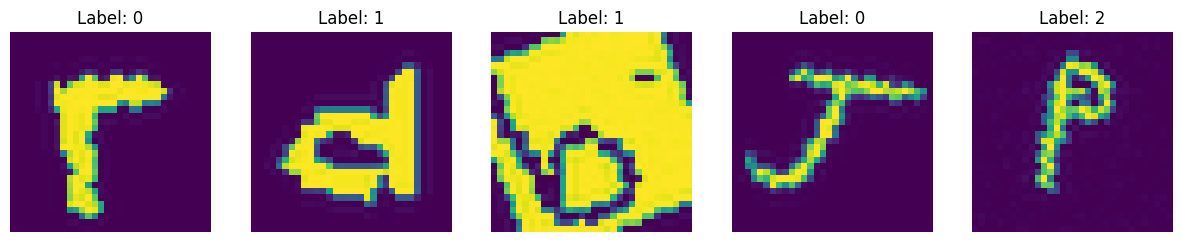

Validation Samples:


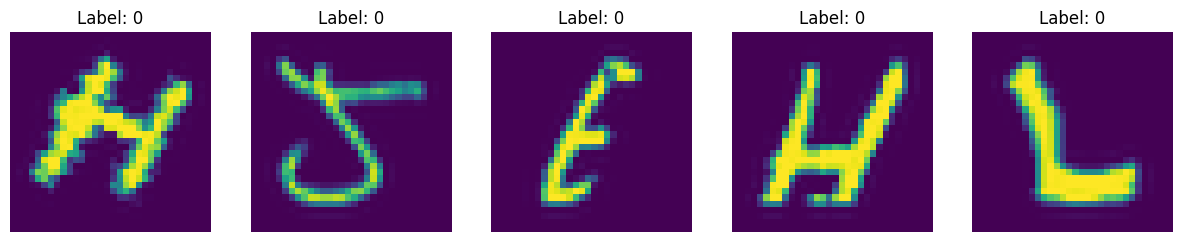

Testing Samples:


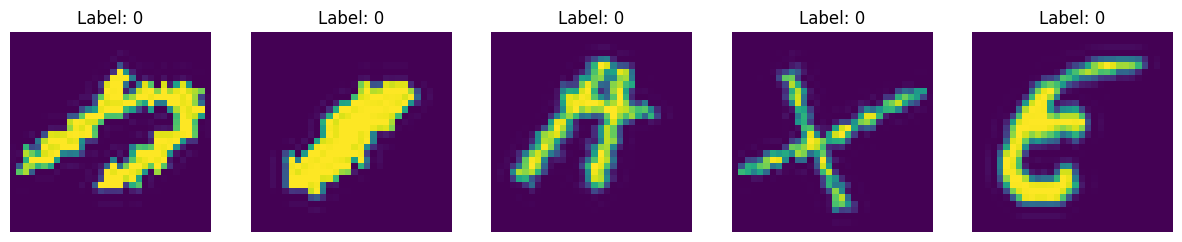

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define a function to visualize images from a DataLoader
def visualize(loader, num_samples=5):
    # Iterate through the DataLoader to get a batch of data
    for batch_idx, (images, labels) in enumerate(loader):
        # Plot the images
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
        for i in range(num_samples):
            ax = axes[i]
            ax.imshow(np.transpose(images[i], (1, 2, 0)))
            ax.set_title(f"Label: {labels[i]}")
            ax.axis('off')
        plt.show()
        break  # Stop after displaying the first batch

# Visualize samples from the training loader
print("Training Samples:")
visualize(train_loader)

# Visualize samples from the validation loader
print("Validation Samples:")
visualize(val_loader)

print("Testing Samples:")
visualize(test_loader)

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# Define the model
class ModifiedLeNet5(nn.Module):
    def __init__(self):
        super(ModifiedLeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(120)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 3)  # 3 classes: Normal, Reversal, Corrected

    def forward(self, x):
        x = F.silu(self.bn1(self.conv1(x)))  # Use SiLU (equivalent to Swish)
        x = self.pool1(x)
        x = F.silu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.silu(self.bn3(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.silu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = ModifiedLeNet5()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train(model, train_loader, val_loader, criterion, optimizer, epochs=20):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                val_acc += accuracy_score(labels.numpy(), outputs.argmax(dim=1).numpy())

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {running_loss / len(train_loader):.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, "
              f"Val Acc: {val_acc / len(val_loader):.4f}")

# Testing loop
def test(model, test_loader):
    model.eval()
    test_acc = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            test_acc += accuracy_score(labels.numpy(), outputs.argmax(dim=1).numpy())
    print(f"Test Accuracy: {test_acc / len(test_loader):.4f}")

# Train and test
train(model, train_loader, val_loader, criterion, optimizer, epochs=20)
test(model, test_loader)

Epoch [1/20], Train Loss: 0.2654, Val Loss: 0.2453, Val Acc: 0.9018
Epoch [2/20], Train Loss: 0.1557, Val Loss: 0.1271, Val Acc: 0.9519
Epoch [3/20], Train Loss: 0.1241, Val Loss: 0.0911, Val Acc: 0.9675
Epoch [4/20], Train Loss: 0.1060, Val Loss: 0.0893, Val Acc: 0.9667
Epoch [5/20], Train Loss: 0.0946, Val Loss: 0.0780, Val Acc: 0.9716
Epoch [6/20], Train Loss: 0.0860, Val Loss: 0.0684, Val Acc: 0.9748
Epoch [7/20], Train Loss: 0.0777, Val Loss: 0.0660, Val Acc: 0.9766
Epoch [8/20], Train Loss: 0.0723, Val Loss: 0.0669, Val Acc: 0.9767
Epoch [9/20], Train Loss: 0.0698, Val Loss: 0.0564, Val Acc: 0.9792
Epoch [10/20], Train Loss: 0.0669, Val Loss: 0.0740, Val Acc: 0.9735
Epoch [11/20], Train Loss: 0.0623, Val Loss: 0.0610, Val Acc: 0.9779
Epoch [12/20], Train Loss: 0.0618, Val Loss: 0.0520, Val Acc: 0.9815
Epoch [13/20], Train Loss: 0.0574, Val Loss: 0.0634, Val Acc: 0.9768
Epoch [14/20], Train Loss: 0.0544, Val Loss: 0.0542, Val Acc: 0.9813
Epoch [15/20], Train Loss: 0.0537, Val Loss

In [ ]:
print(f"Training set size (after augmentation): {len(train_loader)}")
print(f"Validation set size: {len(val_loader)}")
print(f"Test set size: {len(test_loader)}")


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np

def evaluate_model(model, dataloader, device):
    """
    Evaluate the model on a given dataset (e.g., validation or test set).
    Returns:
        - true_labels: Ground truth labels.
        - pred_labels: Predicted labels.
        - accuracy: Overall accuracy.
        - precision: Precision for each class.
        - recall: Recall for each class.
        - f1: F1-score for each class.
        - conf_matrix: Confusion matrix.
    """
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(predicted.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average=None)  # Per-class precision
    recall = recall_score(true_labels, pred_labels, average=None)  # Per-class recall
    f1 = f1_score(true_labels, pred_labels, average=None)  # Per-class F1-score
    conf_matrix = confusion_matrix(true_labels, pred_labels)

    return true_labels, pred_labels, accuracy, precision, recall, f1, conf_matrix

def print_evaluation_metrics(true_labels, pred_labels, accuracy, precision, recall, f1, conf_matrix, class_names):
    """
    Print evaluation metrics in a readable format.
    """
    print(f"Accuracy: {accuracy:.4f}")
    print("\nPer-Class Metrics:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall: {recall[i]:.4f}")
        print(f"  F1-Score: {f1[i]:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix)

def evaluate_on_all_sets(model, train_loader, val_loader, test_loader, device, class_names):
    """
    Evaluate the model on the training, validation, and test sets.
    """
    print("Evaluating on Training Set...")
    train_true, train_pred, train_acc, train_prec, train_rec, train_f1, train_cm = evaluate_model(model, train_loader, device)
    print_evaluation_metrics(train_true, train_pred, train_acc, train_prec, train_rec, train_f1, train_cm, class_names)

    print("\nEvaluating on Validation Set...")
    val_true, val_pred, val_acc, val_prec, val_rec, val_f1, val_cm = evaluate_model(model, val_loader, device)
    print_evaluation_metrics(val_true, val_pred, val_acc, val_prec, val_rec, val_f1, val_cm, class_names)

    print("\nEvaluating on Test Set...")
    test_true, test_pred, test_acc, test_prec, test_rec, test_f1, test_cm = evaluate_model(model, test_loader, device)
    print_evaluation_metrics(test_true, test_pred, test_acc, test_prec, test_rec, test_f1, test_cm, class_names)